In [1]:
import os
os.getcwd()

'/Users/yuechenjiang/Desktop/CatMemo'

In [2]:
cd /Users/yuechenjiang/Desktop/CatMemo/result

/Users/yuechenjiang/Desktop/CatMemo/result


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

def get_data(Start:str, End:str, ticker:str, df_Me, df_park, df_GPT, df_A2C, df_PPO, df_DQN):
    """
    Downloads stock data and filters dataframes based on the given date range.
    """
    # Download stock data from Yahoo Finance
    df = yf.download(ticker, start=Start, end=End)

    # Convert date columns to datetime objects for filtering
    df_Me['date'] = pd.to_datetime(df_Me['date'])
    df_GPT['dates'] = pd.to_datetime(df_GPT['dates'])
    # Add Park Here 1
    df_park['date'] = pd.to_datetime(df_park['date'])
    df_A2C['date'] = pd.to_datetime(df_A2C['date'])
    df_PPO['date'] = pd.to_datetime(df_PPO['date'])
    df_DQN['date'] = pd.to_datetime(df_DQN['date'])

    # Filter data within the specified date range and extract relevant columns
    FinMe = df_Me[(df_Me['date'] >= Start) & (df_Me['date'] < End)]['direction'].tolist()
    FinGPT = df_GPT[(df_GPT['dates'] >= Start) & (df_GPT['dates'] < End)]['actions'].tolist()
    # Add Park Here 2
    Park = df_park[(df_park['date'] >= Start) & (df_park['date'] < End)]['direction'].tolist()
    A2C = df_A2C[(df_A2C['date'] >= Start) & (df_A2C['date'] < End)]['action'].tolist()
    PPO = df_PPO[(df_PPO['date'] >= Start) & (df_PPO['date'] < End)]['action'].tolist()
    DQN = df_DQN[(df_DQN['date'] >= Start) & (df_DQN['date'] < End)]['action'].tolist()
    
    return df['Adj Close'].tolist(), FinMe, Park, FinGPT, A2C, PPO, DQN

def reward_list(price:list, actions:list):
    """
    Calculates the cumulative reward for a given list of prices and actions.
    """
    reward = 0
    reward_list = [0]
    for i in range(len(price)-1):
        reward += actions[i] * np.log(price[i+1]/price[i])
        reward_list.append(reward)
    return reward_list

def plot_cumulative_returns(dates, return_lists, labels, colors, linestyles, alphas, linewidths, ticker, file_path,  Start_Date = True):
    fig, ax = plt.subplots(figsize=(18, 10))
    
    # Loop through the return lists and plot each one
    for returns, label, color, linestyle, alpha, linewidth in zip(return_lists, labels, colors, linestyles, alphas, linewidths):
        ax.plot(dates, returns, label=label, color=color, linestyle=linestyle, alpha=alpha, linewidth=linewidth)
    
    # Set the labels and title
    ax.set_xlabel('Date', fontsize=28)
    ax.set_ylabel('Cumulative Return', fontsize=28)
    plt.title(ticker, fontsize=35)

    # Customize the legend
    ax.legend(fontsize=22, frameon=True)

    # Customize the grid
    ax.grid(True)

    # Customize the tick labels on both axes
    ax.tick_params(axis='x', labelsize=22, width=2, rotation=45)  # Rotate x-axis labels
    ax.tick_params(axis='y', labelsize=22, width=2)  # y-axis labels
    # ax.set_ylim(-1.2, 0.9)
    
    # Set x-ticks to start from a specific date
    if Start_Date:
        start_date = datetime(2022, 10, 1)
        ax.set_xlim(left=start_date)
        # ax.set_ylim(-0.85, 0.7)
    else:
        end_date = datetime(2023,4,30)
        ax.set_xlim(right=end_date)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to monthly intervals
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())  # Set minor ticks to weekly intervals

    # Apply tight layout to ensure everything fits without overlapping
    plt.tight_layout()

    # Save the plot as a .png file with 300 dpi
    plt.savefig(file_path, format='png', dpi=300)

    # Display the plot
    plt.show()


def main(Ticker, start_time, end_time, df_Me_file, df_park_file, df_GPT_file, df_A2C_file, df_PPO_file, df_DQN_file, image_save_path, Start_Date = True):

    # Get data
    price, FinMe, Park, FinGPT, A2C, PPO, DQN = get_data(
        Start=start_time, 
        End=end_time, 
        ticker=Ticker, 
        df_Me=df_Me_file, 
        df_GPT=df_GPT_file, 
        df_park=df_park_file,
        df_A2C=df_A2C_file, 
        df_PPO=df_PPO_file, 
        df_DQN=df_DQN_file
    )

    # Calculate rewards
    B_H = [1] * len(price)
    B_H_rw = reward_list(price, B_H)
    FinMe_rw = reward_list(price, FinMe)
    Park_rw = reward_list(price, Park)
    FinGPT_rw = reward_list(price, FinGPT)
    PPO_rw = reward_list(price, PPO)
    # print(B_H_rw, PPO_rw)
    A2C_rw = reward_list(price, A2C)
    DQN_rw = reward_list(price, DQN)
    
    # Prepare data for plotting
    Date = df_Me_file[(df_Me_file['date'] >= start_time) & (df_Me_file['date'] < end_time)]['date'].tolist()
    dates = pd.to_datetime(Date).tolist()
    # print(len(Date), len(B_H_rw))
    return_lists = [B_H_rw, FinMe_rw, Park_rw, FinGPT_rw, A2C_rw, PPO_rw, DQN_rw]
    # labels = ['B&H', 'FinMe', 'FinGPT', 'A2C', 'PPO', 'DQN'] # Park
    # colors = ['#000', '#d14749', '#4e89e0', '#ee4199', '#f28e2b', '#8F337F'] # color = '#59a14f',
    labels = ['B&H', 'FinMem', 'GA', 'FinGPT', 'A2C', 'PPO', 'DQN'] # Park
    colors = ['#000', '#d14749', '#59a14f', '#4e89e0', '#ee4199', '#f28e2b', '#8F337F'] # color = ,
    linestyles = ['-.', '-', '-', '-', '-', '-', '-']
    # alphas = [0.7, 1, 1, 0.7, 0.7, 0.7]
    linewidths = [2.5, 3.5, 2.5, 2.5, 2.5, 2.5, 2.5]
    alphas = [0.66, 1, 1, 1, 0.66, 0.66, 0.66]

    # Plot the cumulative returns
    plot_cumulative_returns(
        dates=dates,
        return_lists=return_lists,
        labels=labels,
        colors=colors,
        linestyles=linestyles,
        alphas=alphas,
        linewidths=linewidths,
        ticker=Ticker,
        file_path=image_save_path,
        Start_Date = Start_Date
    )

[*********************100%%**********************]  1 of 1 completed


/var/folders/kg/pwzs55h51hb6x5vbsqjvxhjc0000gn/T/ipykernel_96787/1086707386.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_Me['date'] = pd.to_datetime(df_Me['date'])
/var/folders/kg/pwzs55h51hb6x5vbsqjvxhjc0000gn/T/ipykernel_96787/1086707386.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_park['date'] = pd.to_datetime(df_park['date'])


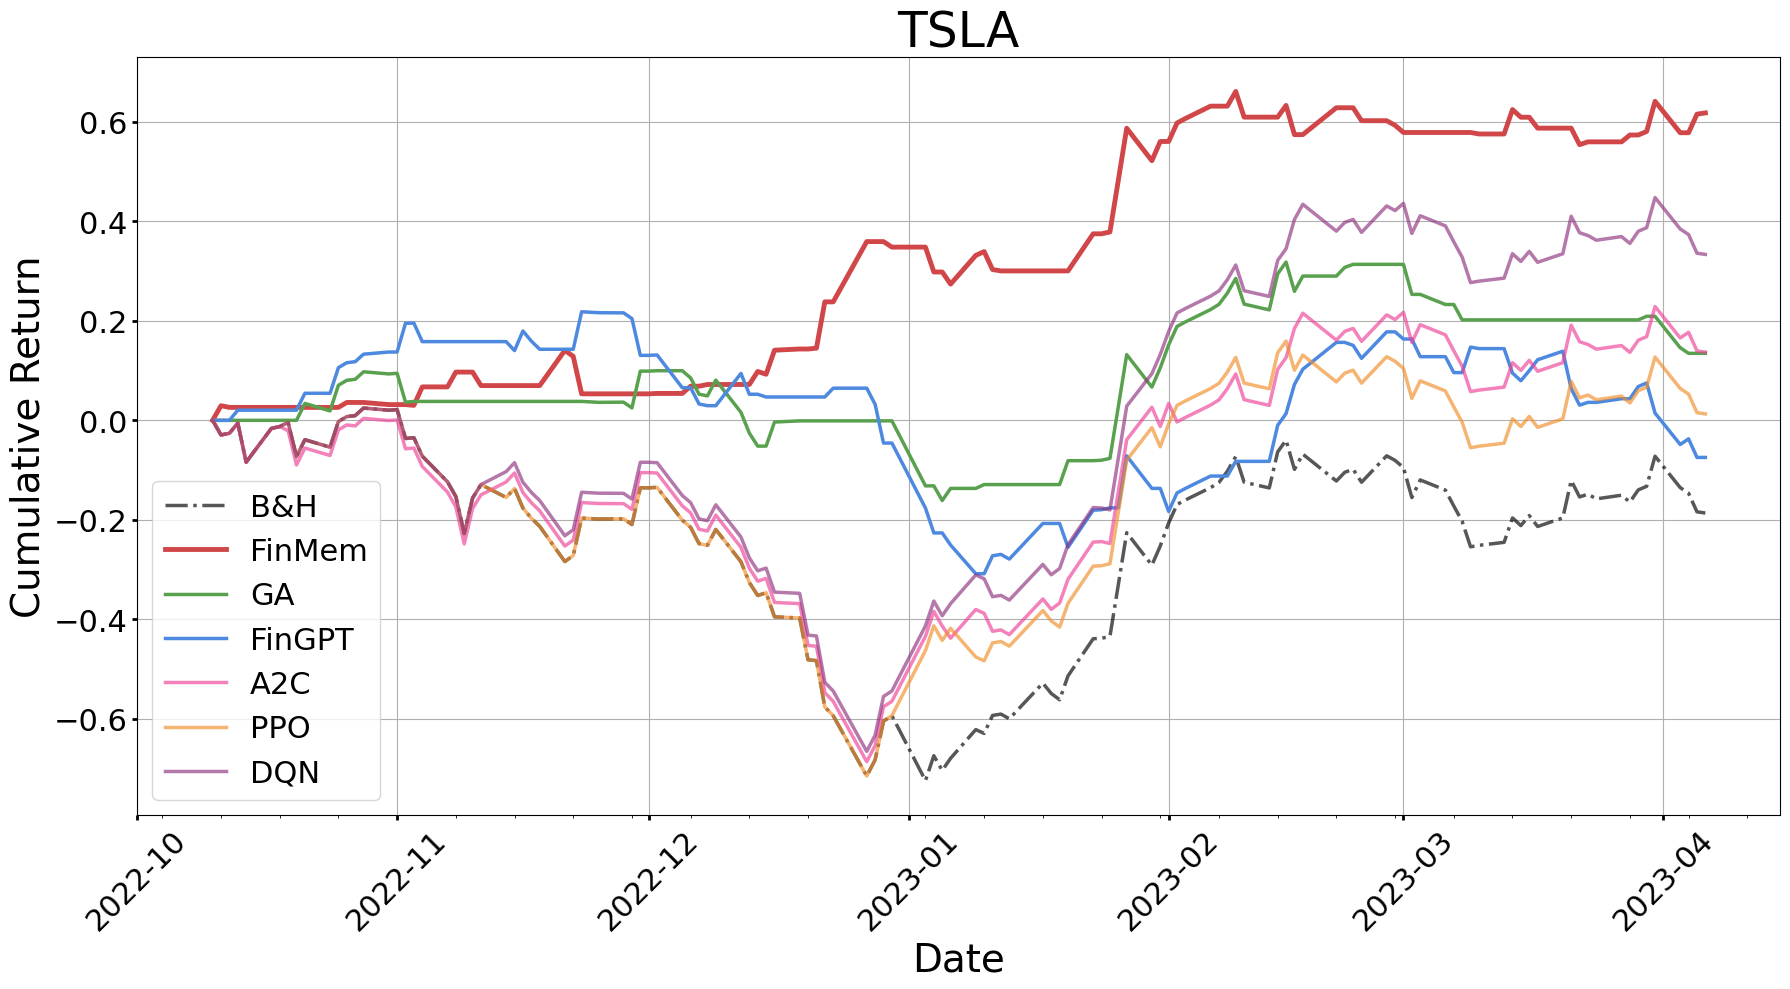

[*********************100%%**********************]  1 of 1 completed


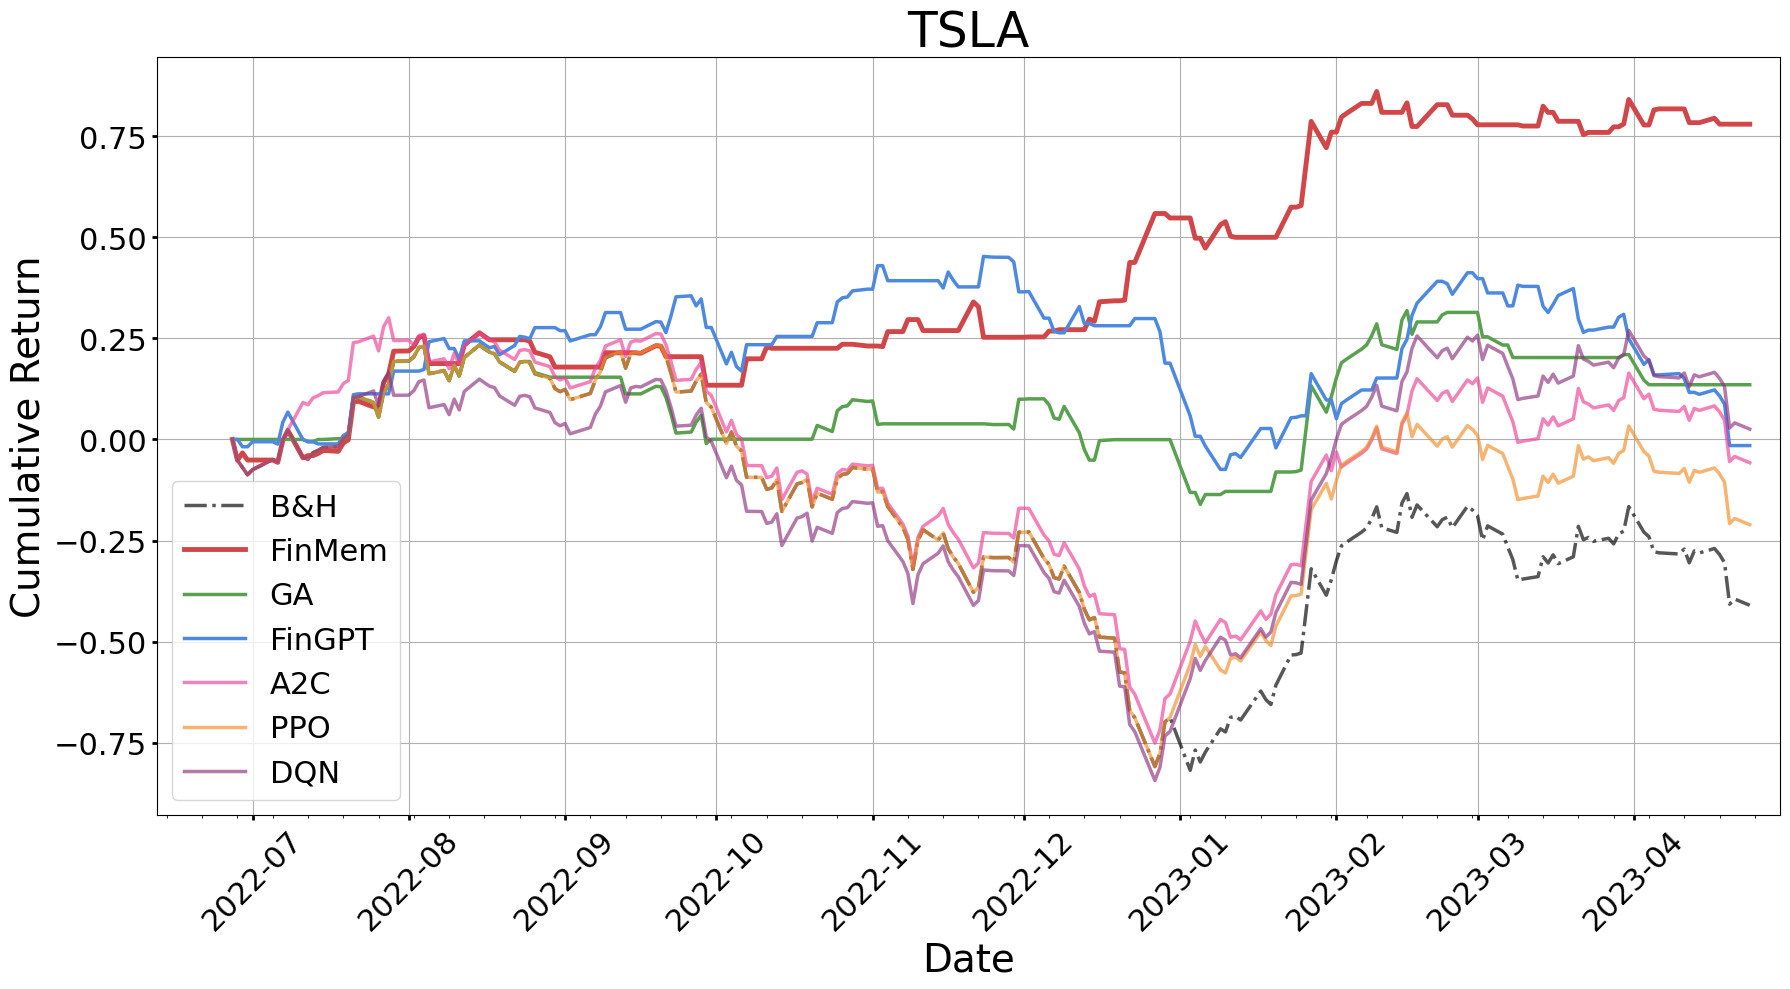

In [4]:
if __name__ == '__main__':
    df_PPO_TSLA = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/result/TSLA_PPO_summary_data_seed1_full.csv')
    df_A2C_TSLA = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/result/TSLA_A2C_summary_data_seed2_full.csv')
    df_DQN_TSLA = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/result/TSLA_DQN_summary_data_seed1_full.csv')
    df_GPT_TSLA = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/BenchMark/fingpt/tsla_curie.csv')
    df_Me_TSLA = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/result/Tsla-new-full.csv')
    df_park_TSLA = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/result/action_df_tsla_park_v2.csv')
    image_save_path_TSLA_part = '/Users/yuechenjiang/Desktop/CatMemo/Final_result/Park_test/TSLA2022-10-06-2023-04-10.png'
    image_save_path_TSLA_all = '/Users/yuechenjiang/Desktop/CatMemo/Final_result/Park_test/TSLA2022-06-25-2023-04-25.png'
    main(Ticker = 'TSLA', 
         start_time = '2022-10-06', 
         end_time = '2023-04-10', 
         df_Me_file = df_Me_TSLA, 
         df_park_file = df_park_TSLA,
         df_GPT_file = df_GPT_TSLA, 
         df_A2C_file = df_A2C_TSLA, 
         df_PPO_file = df_PPO_TSLA, 
         df_DQN_file = df_DQN_TSLA,
         image_save_path = image_save_path_TSLA_part)
    # df_Me_TSLA = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/Final_result/change_LLM/TSLA_GPT4.csv')
    main(Ticker = 'TSLA', 
         start_time = '2022-06-25', 
         end_time = '2023-04-25', 
         df_Me_file = df_Me_TSLA, 
         df_park_file = df_park_TSLA,
         df_GPT_file = df_GPT_TSLA, 
         df_A2C_file = df_A2C_TSLA, 
         df_PPO_file = df_PPO_TSLA, 
         df_DQN_file = df_DQN_TSLA,
         image_save_path = image_save_path_TSLA_all,
         Start_Date = False)

[*********************100%%**********************]  1 of 1 completed


/var/folders/kg/pwzs55h51hb6x5vbsqjvxhjc0000gn/T/ipykernel_96787/1086707386.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_Me['date'] = pd.to_datetime(df_Me['date'])


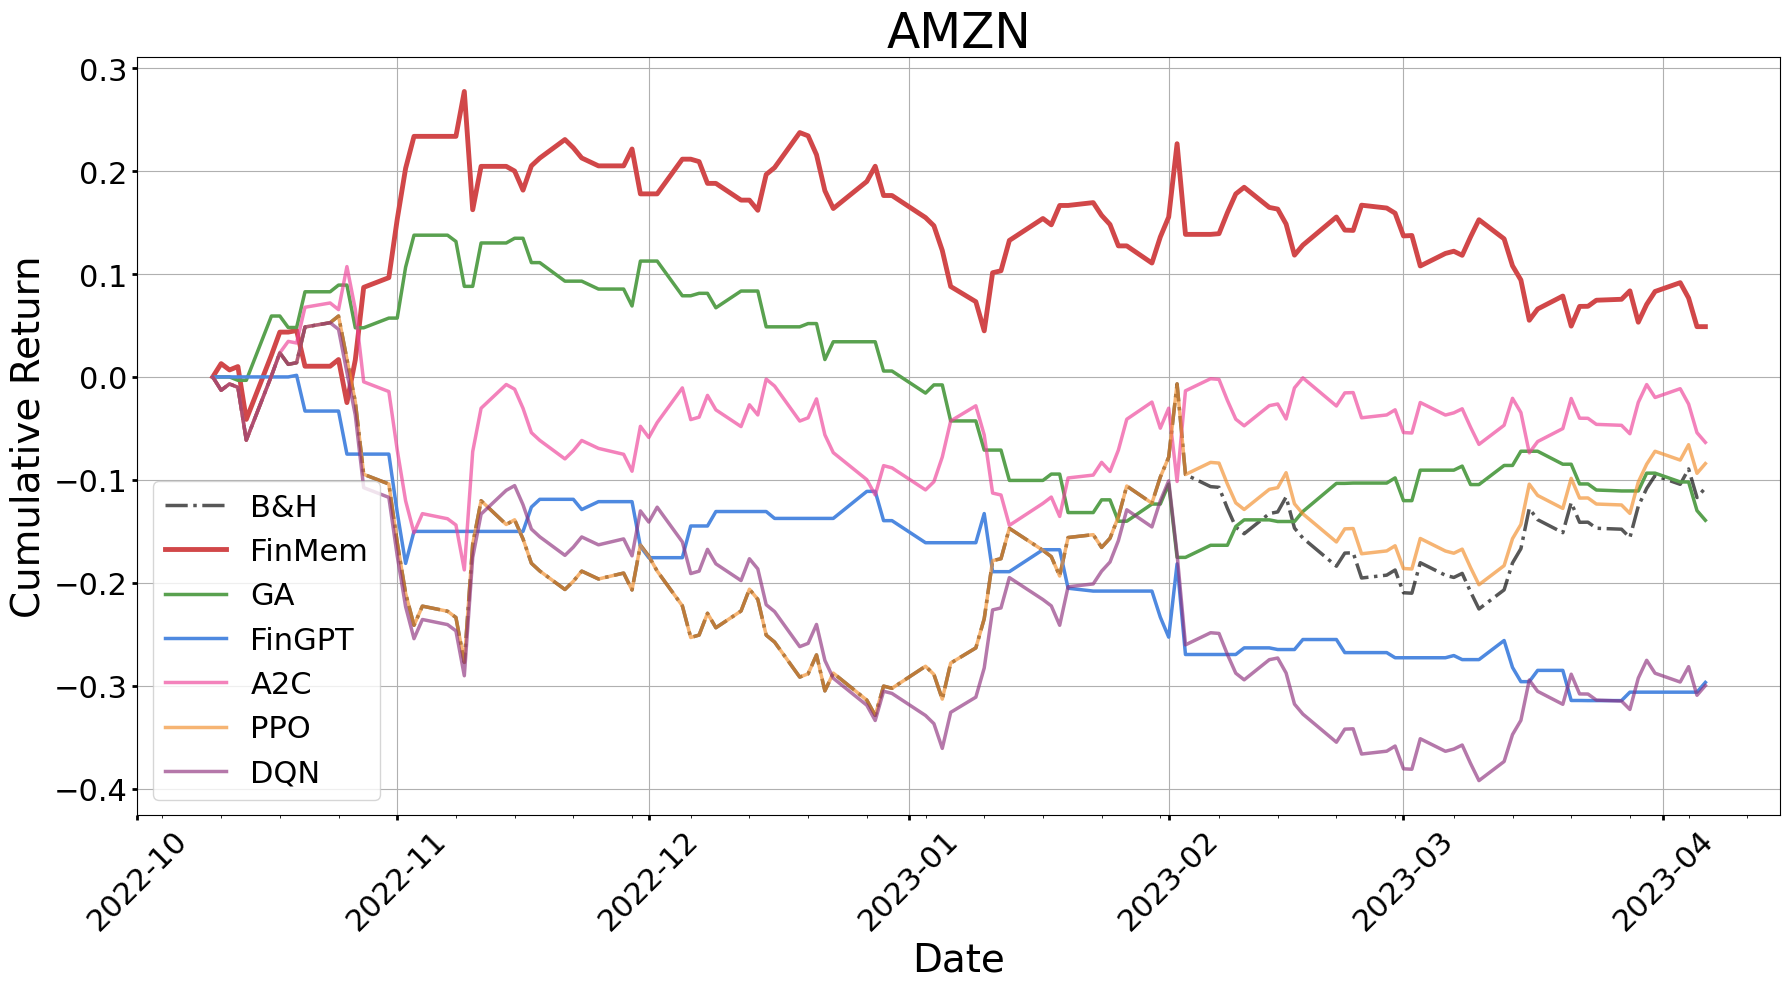

In [5]:
if __name__ == '__main__':
    df_Me_AMZN = pd.read_csv('dat_df_amzn_new_v5.csv')
    df_GPT_AMZN = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/BenchMark/fingpt/amzn_curie-001.csv')
    df_park_AMZN = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/result/AMZN111.csv')
    df_A2C_AMZN = pd.read_csv('AMZN_A2C_summary_data_seed0.csv')
    df_PPO_AMZN = pd.read_csv('AMZN_PPO_summary_data_seed2_new.csv')
    df_DQN_AMZN = pd.read_csv('AMZN_DQN_summary_data_seed2.csv')
    image_save_path_AMZN = '/Users/yuechenjiang/Desktop/CatMemo/Final_result/Park_test/AMZN2022-10-06-2023-04-10.png'
    main(Ticker = 'AMZN', 
         start_time = '2022-10-06', 
         end_time = '2023-04-10', 
         df_Me_file = df_Me_AMZN, 
         df_park_file = df_park_AMZN,
         df_GPT_file = df_GPT_AMZN, 
         df_A2C_file = df_A2C_AMZN, 
         df_PPO_file = df_PPO_AMZN, 
         df_DQN_file = df_DQN_AMZN,
         image_save_path = image_save_path_AMZN)

[*********************100%%**********************]  1 of 1 completed


/var/folders/kg/pwzs55h51hb6x5vbsqjvxhjc0000gn/T/ipykernel_96787/1086707386.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_Me['date'] = pd.to_datetime(df_Me['date'])
/var/folders/kg/pwzs55h51hb6x5vbsqjvxhjc0000gn/T/ipykernel_96787/1086707386.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_park['date'] = pd.to_datetime(df_park['date'])


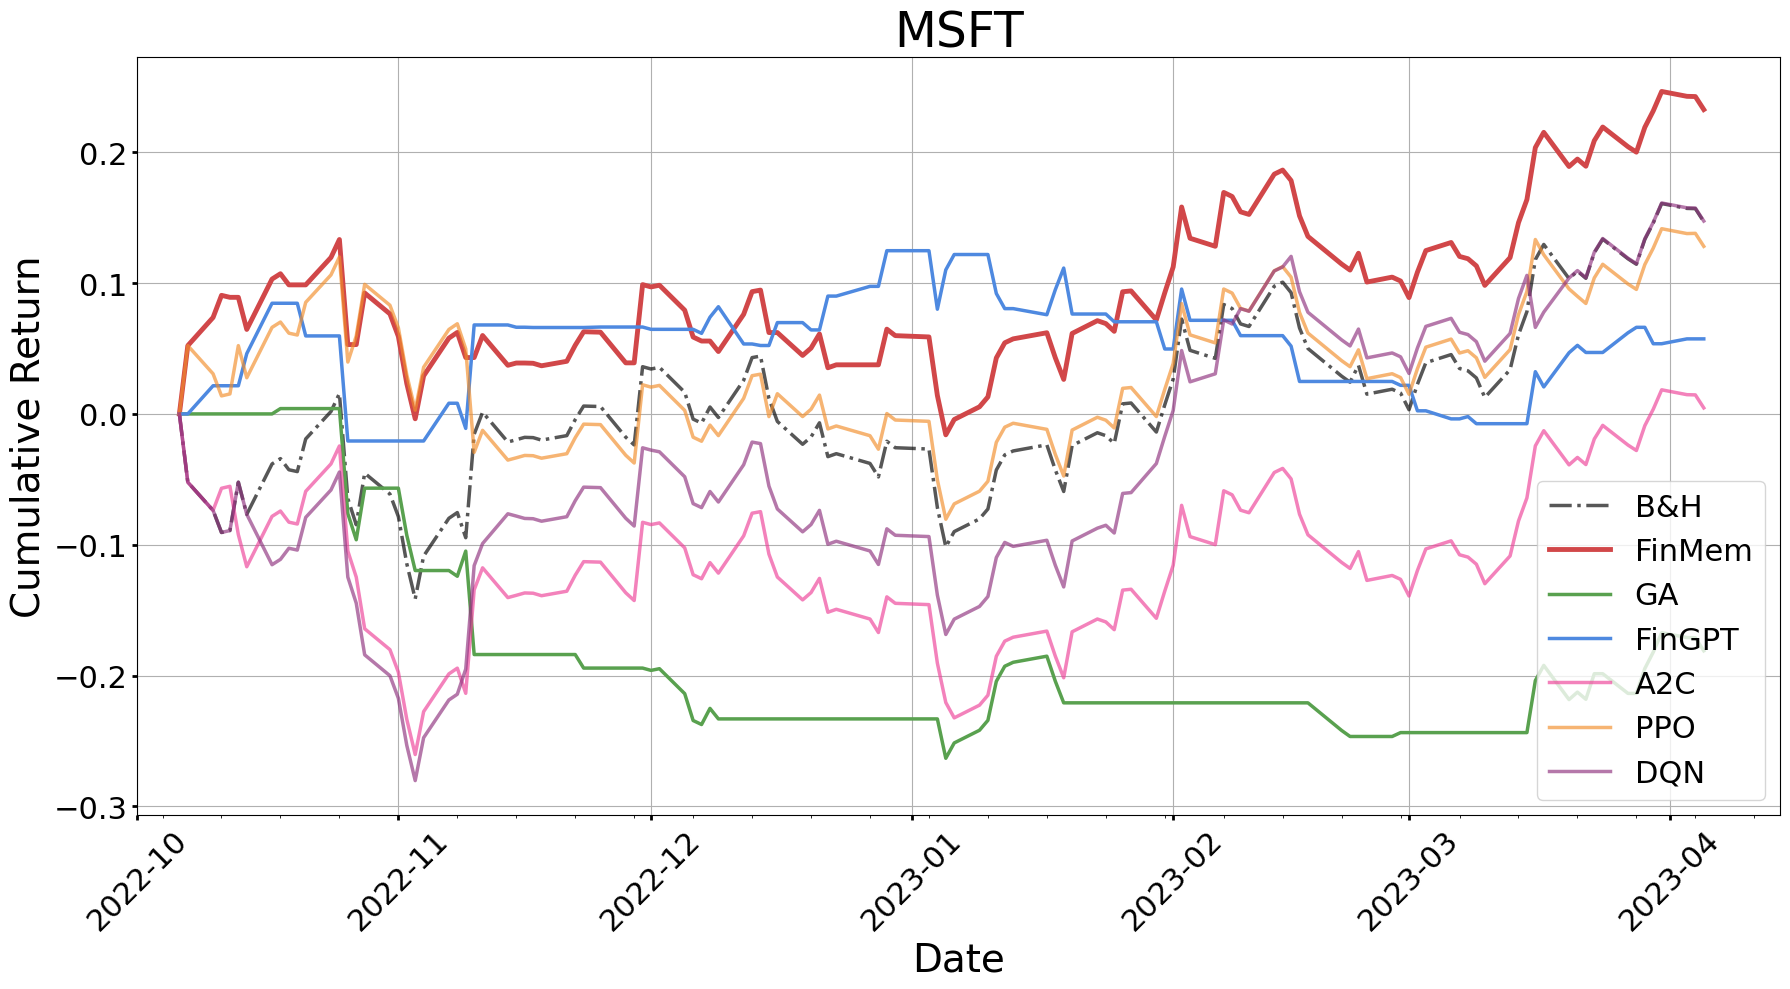

In [6]:
if __name__ == '__main__':
    df_Me_MSFT = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/result/dat_df_msft_renewed_seeking_v8.csv')
    df_park_MSFT = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/result/action_df_msft_v2_park.csv')
    df_A2C_MSFT = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/result/MSFT_A2C_summary_data_full.csv')
    df_PPO_MSFT = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/result/MSFT_PPO_summary_data_2.csv')
    df_DQN_MSFT = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/result/MSFT_DQN_summary_data.csv')
    df_GPT_MSFT = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/BenchMark/fingpt/msft_curie_001.csv')
    image_save_path_MSFT = '/Users/yuechenjiang/Desktop/CatMemo/Final_result/Park_test/MSFT2022-10-06-2023-04-10.png'
    main(Ticker = 'MSFT', 
         start_time = '2022-10-06', 
         end_time = '2023-04-10', 
         df_Me_file = df_Me_MSFT, 
         df_park_file = df_park_MSFT,
         df_GPT_file = df_GPT_MSFT, 
         df_A2C_file = df_A2C_MSFT, 
         df_PPO_file = df_PPO_MSFT, 
         df_DQN_file = df_DQN_MSFT,
         image_save_path = image_save_path_MSFT)

[*********************100%%**********************]  1 of 1 completed


/var/folders/kg/pwzs55h51hb6x5vbsqjvxhjc0000gn/T/ipykernel_96787/1086707386.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_Me['date'] = pd.to_datetime(df_Me['date'])
/var/folders/kg/pwzs55h51hb6x5vbsqjvxhjc0000gn/T/ipykernel_96787/1086707386.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_GPT['dates'] = pd.to_datetime(df_GPT['dates'])


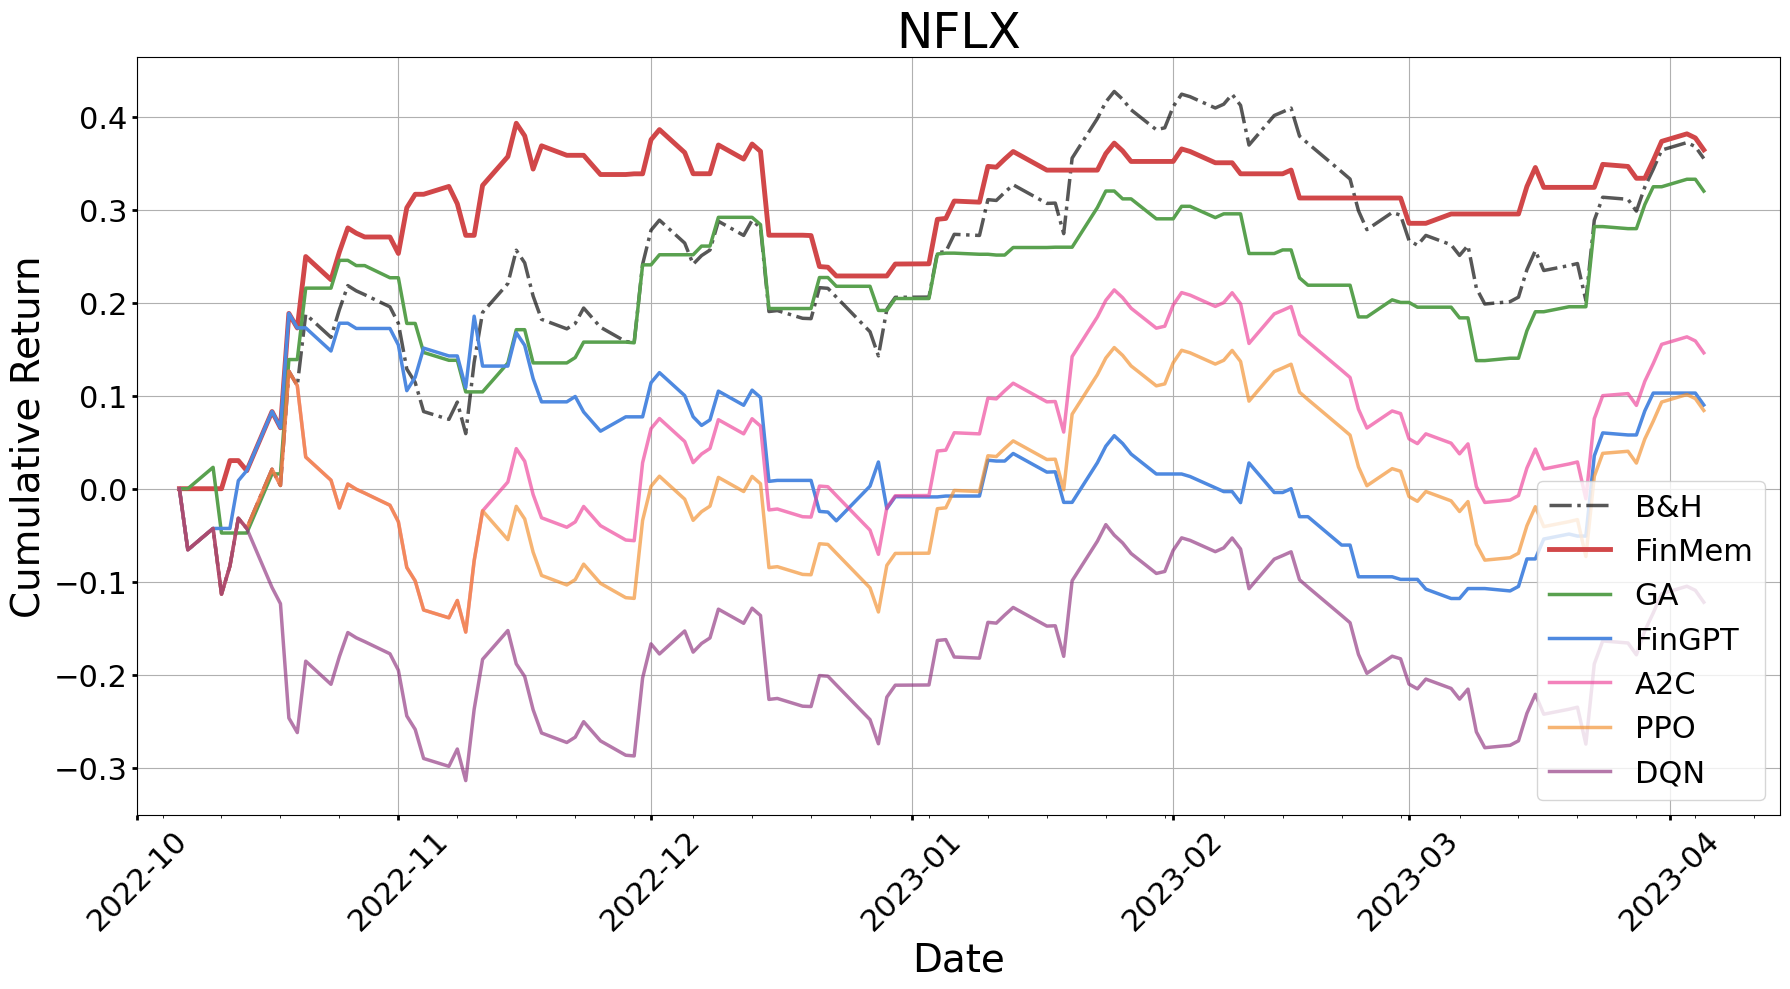

In [7]:
if __name__ == '__main__':
    df_Me_NFLX = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/result/dat_df_nflx_new_v3.csv')
    df_park_NFLX = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/result/NFLX111.csv')
    df_GPT_NFLX = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/BenchMark/fingpt/nflx_curie.csv')
    df_PPO_NFLX = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/result/NFLX_PPO_summary_data_seed2.csv')
    df_DQN_NFLX = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/result/NFLX_DQN_summary_data_seed1.csv')
    df_A2C_NFLX = pd.read_csv('/Users/yuechenjiang/Desktop/CatMemo/result/NFLX_A2C_summary_data_seed0.csv')
    image_save_path_NFLX = '/Users/yuechenjiang/Desktop/CatMemo/Final_result/Park_test/NFLX-2022-10-06-2023-04-10.png'
    main(Ticker = 'NFLX', 
         start_time = '2022-10-06', 
         end_time = '2023-04-10', 
         df_Me_file = df_Me_NFLX, 
         df_park_file = df_park_NFLX,
         df_GPT_file = df_GPT_NFLX, 
         df_A2C_file = df_A2C_NFLX, 
         df_PPO_file = df_PPO_NFLX, 
         df_DQN_file = df_DQN_NFLX,
         image_save_path = image_save_path_NFLX)

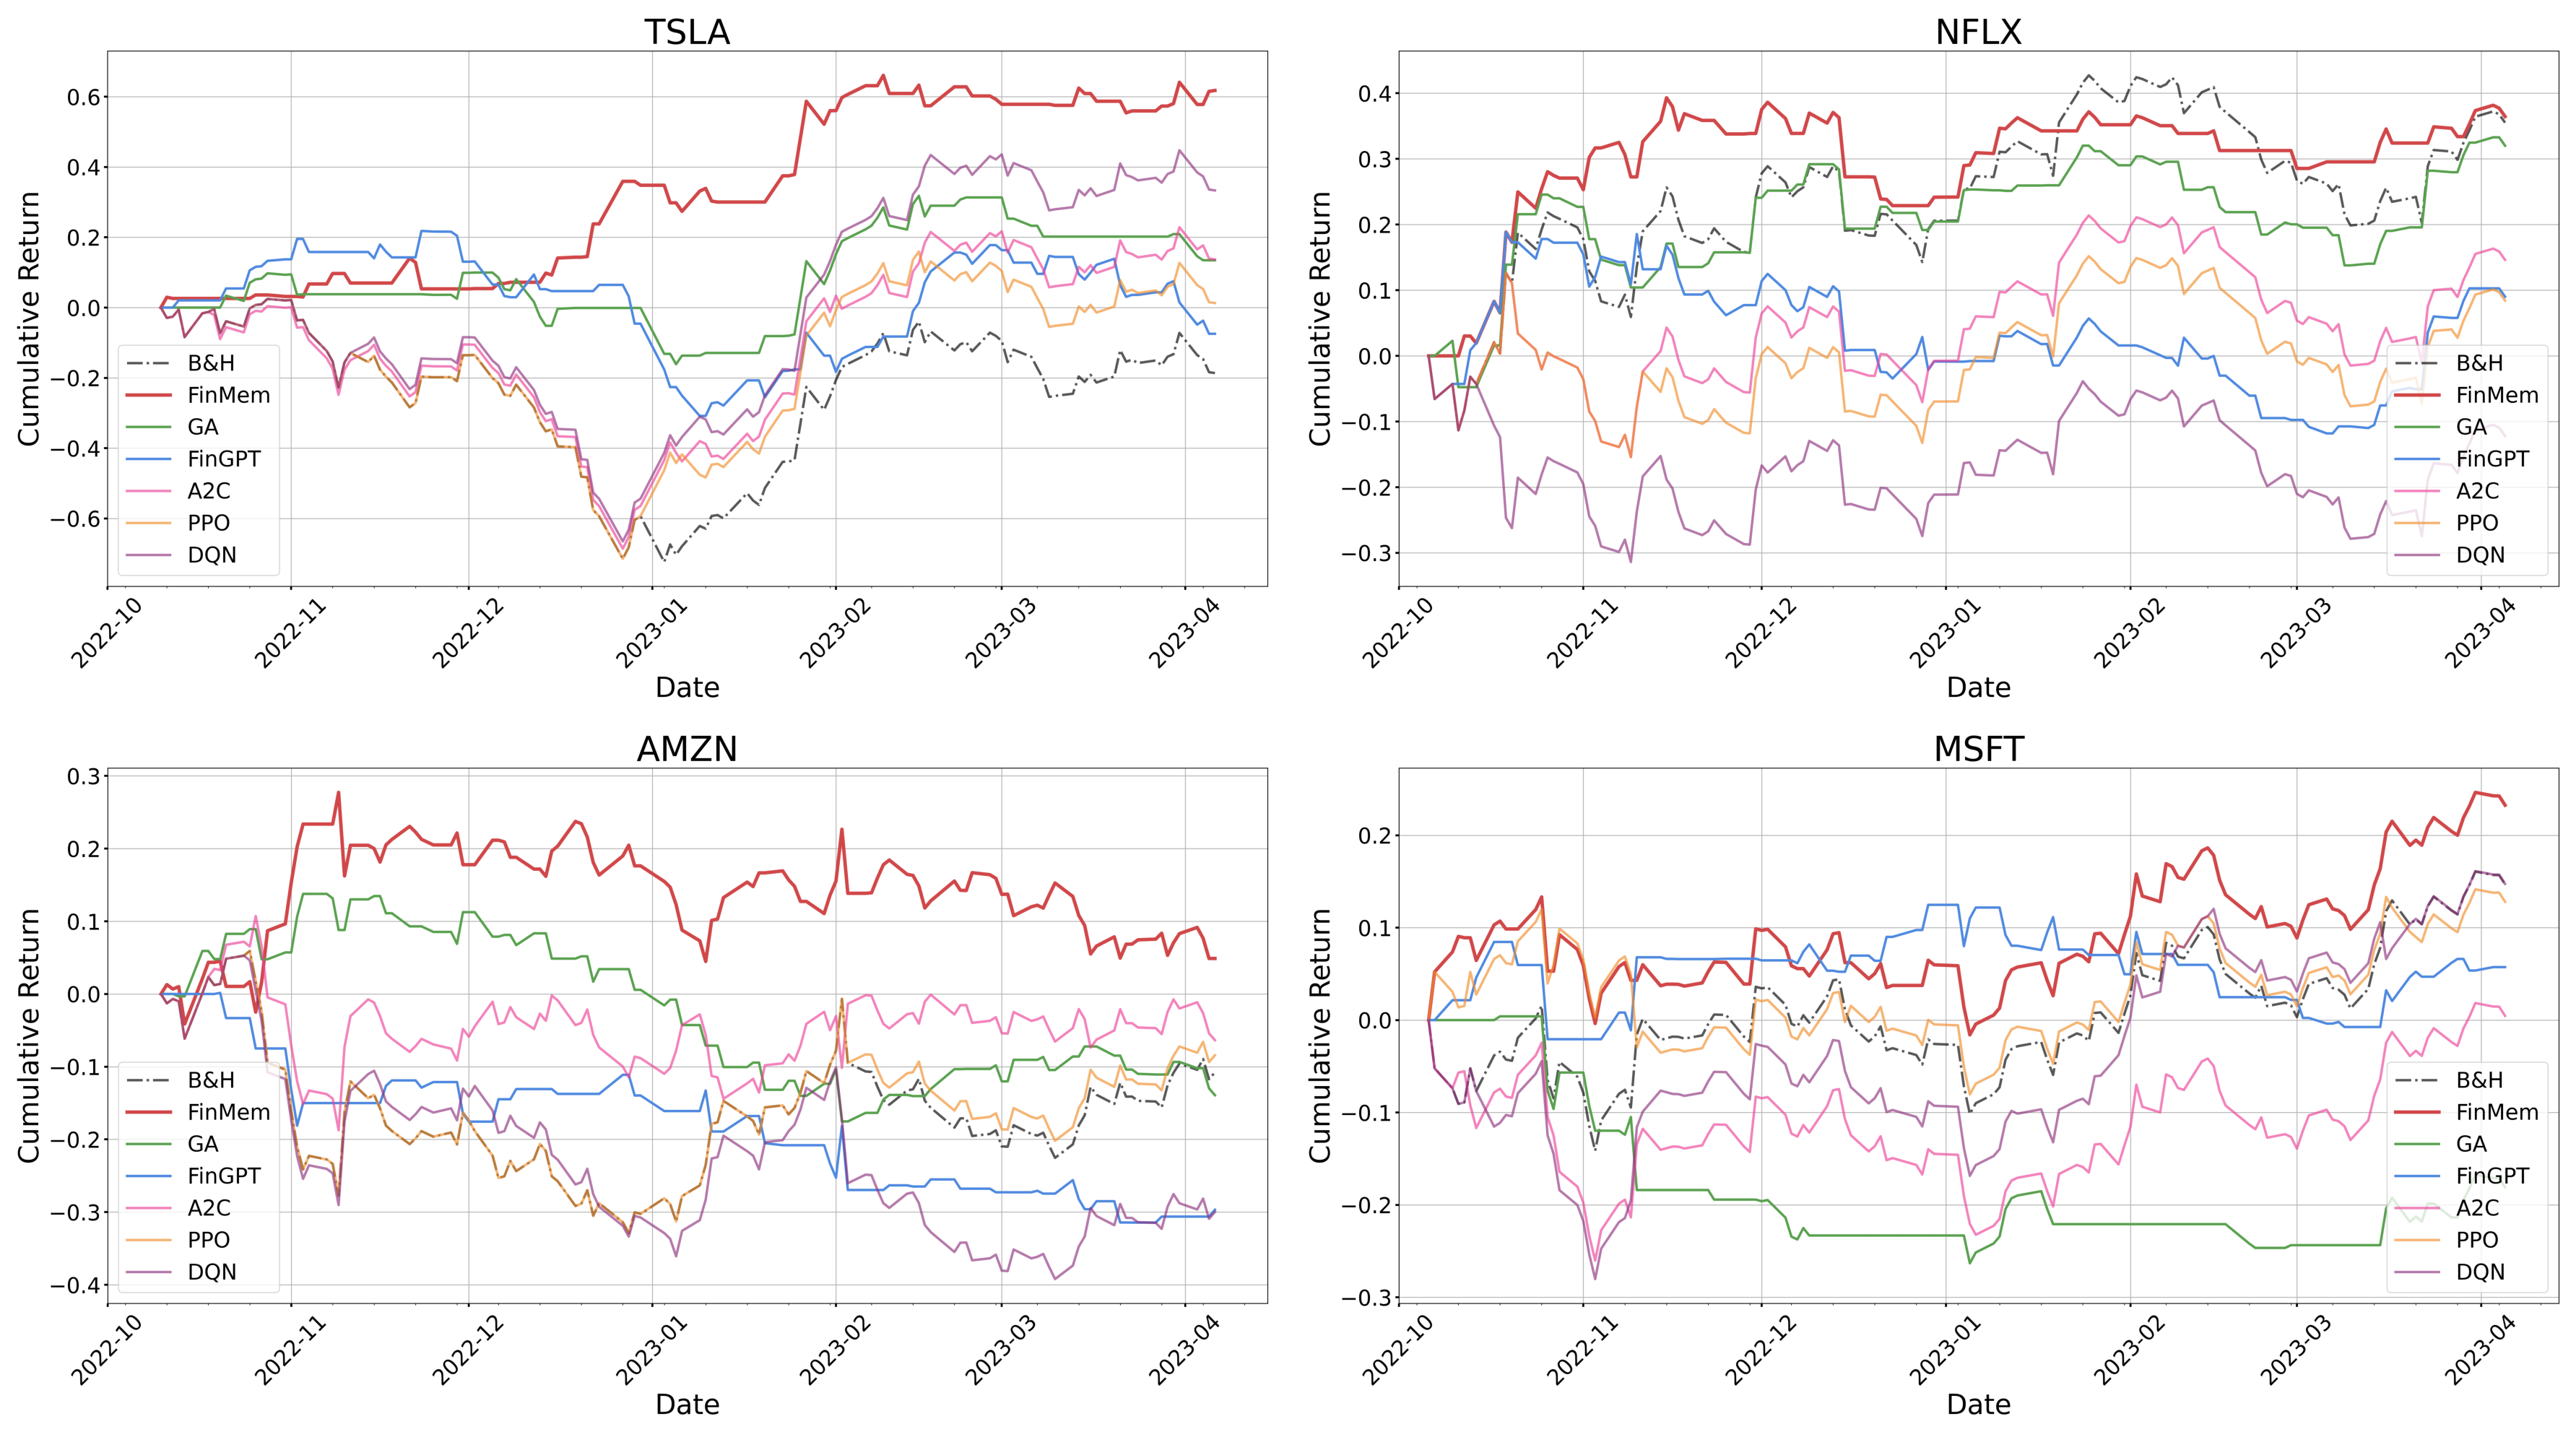

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

# Paths to your PNG files
image_paths = [image_save_path_TSLA_part, image_save_path_NFLX, 
               image_save_path_AMZN, image_save_path_MSFT]

# Create a 2x2 grid for the images
fig, axs = plt.subplots(2, 2, figsize=(36, 20))

# Iterate over the grid and add images
for i, ax in enumerate(axs.flatten()):
    img = Image.open(image_paths[i])
    ax.imshow(img)
    ax.axis('off')  # Turn off axis

plt.tight_layout()

plt.savefig('/Users/yuechenjiang/Desktop/CatMemo/Final_result/Park_test/Combined-result.png', format='png', dpi=300)

plt.show()
